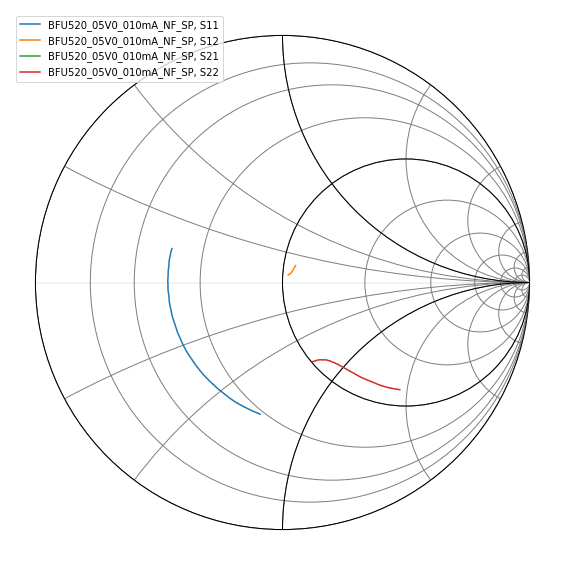

In [2]:
import numpy as np

import skrf
import skrf.media as media
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(0.4, 2, 1001)
tem = media.DistributedCircuit(f, z0=50)

bjt = net.Network('BFU520_Spar_NF_400MHz-2GHz/BFU520_05V0_010mA_NF_SP.s2p').interpolate(f)

bjt

bjt.plot_s_smith()

In [3]:
# calculate the stability circles for the source and load impedances

idx_900mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

sqabs = lambda x: np.square(np.absolute(x))

delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s))/(sqabs(bjt.s22.s) - sqabs(delta))

rl_900mhz = rl[idx_900mhz][0, 0]
cl_900mhz = cl[idx_900mhz][0, 0]

rl_900mhz, cl_900mhz

(4.105588512516754, (2.478775227242761+4.2244480827589j))

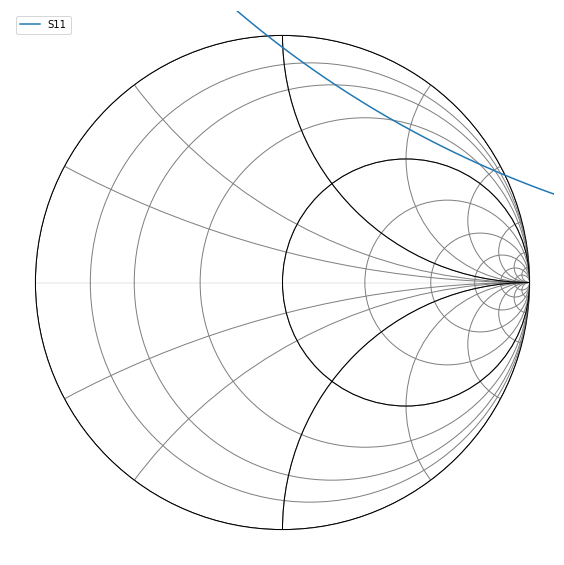

In [4]:
def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def plot_smith(pts):
    n = net.Network(s=pts)
    n.plot_s_smith()
    
cl_points = calc_circle(cl_900mhz, rl_900mhz)
plot_smith(cl_points)

2.8820382027100058 (-3.371227372367411+1.4990710463003132j)


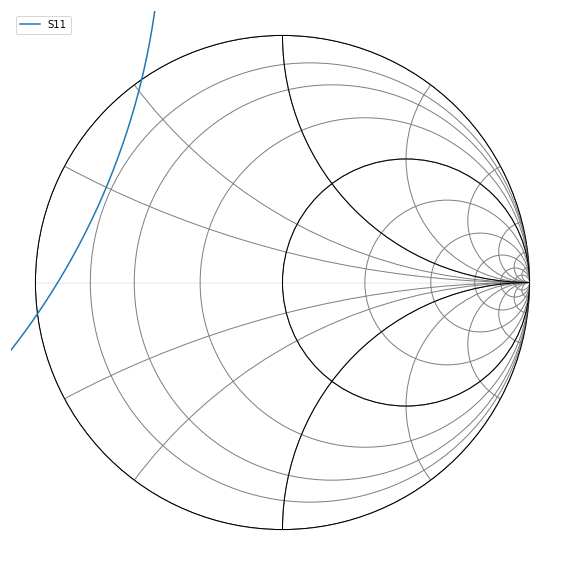

In [5]:
rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s))/(sqabs(bjt.s11.s) - sqabs(delta))

rs_900mhz = rs[idx_900mhz][0, 0]
cs_900mhz = cs[idx_900mhz][0, 0]

print(rs_900mhz, cs_900mhz)

cs_points = calc_circle(cs_900mhz, rs_900mhz)
plot_smith(cs_points)

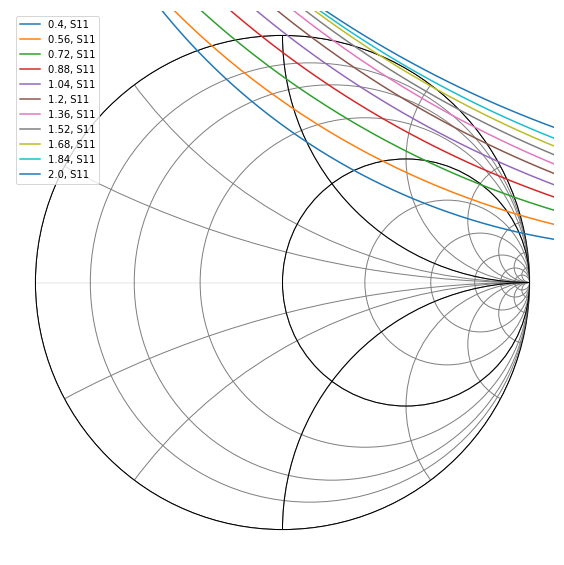

In [6]:
# let's plot all of them
# output stability first

for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
    n.plot_s_smith()

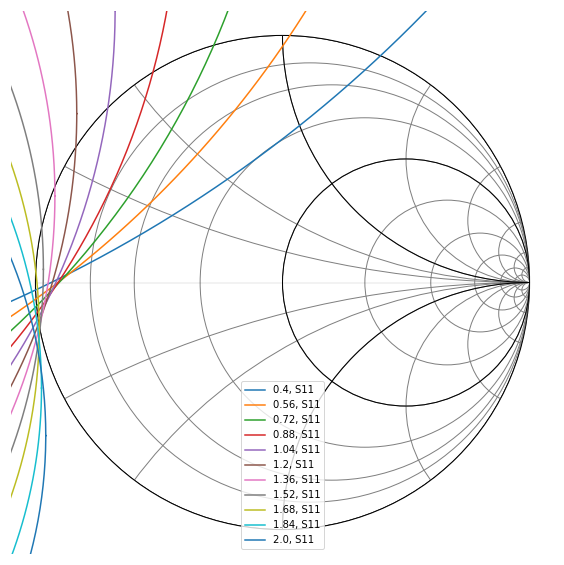

In [7]:
# input stability
for i, f in enumerate(bjt.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
    n.plot_s_smith()

21.769786511748308


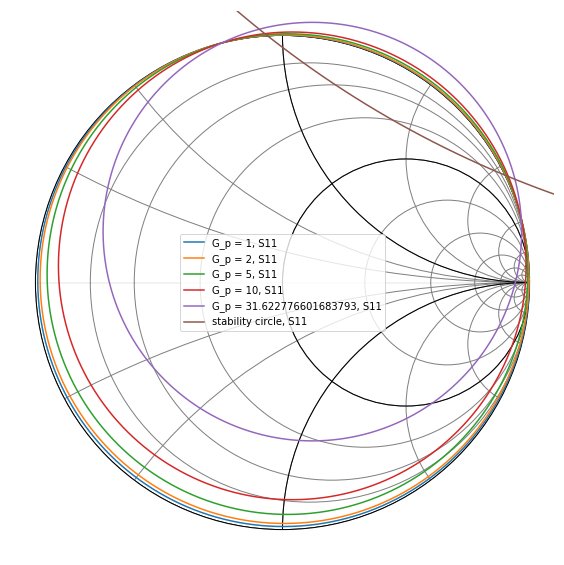

In [8]:
# so not very useful, because the transistor isn't unconditionally stable
# time to draw the circles of constant gain and try to find a useful point

K = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) - sqabs(delta))/(2*np.absolute((bjt.s12.s)*(bjt.s21.s)))
G_msg = np.absolute(bjt.s21.s)/np.absolute(bjt.s12.s)
print(10*np.log10(G_msg[idx_900mhz, 0, 0]))

# let's draw a bunch of curves I guess

b1 = 1 + sqabs(bjt.s11.s) - sqabs(bjt.s22.s) - sqabs(delta)
b2 = 1 + sqabs(bjt.s22.s) - sqabs(bjt.s11.s) - sqabs(delta)
c1 = bjt.s11.s - delta * np.conj(bjt.s22.s)
c2 = bjt.s22.s - delta * np.conj(bjt.s11.s)

gamma_ms = (b1 - np.sqrt(np.square(b1) - 4 * sqabs(c1) + 0.j))/(2*c1)
gamma_ml = (b2 - np.sqrt(np.square(b2) - 4 * sqabs(c2) + 0.j))/(2*c2)

for G_p in [1, 2, 5, 10, 10**(15/10)]:
    g_p = G_p/sqabs(bjt.s21.s)
    r_p = (1 - 2*K*np.absolute(bjt.s12.s*bjt.s21.s)*g_p + sqabs(bjt.s12.s*bjt.s21.s)*(g_p**2))**(0.5)/np.absolute(1 + g_p * (sqabs(bjt.s22.s) - sqabs(delta)))
    c_p = (g_p * np.conj(c2))/(1 + g_p*(sqabs(bjt.s22.s) - sqabs(delta)))
    r, c = r_p[idx_900mhz, 0, 0], c_p[idx_900mhz, 0, 0]
    #print(g_p, r, c)
    points = calc_circle(c, r)
    n = net.Network(name = 'G_p = {}'.format(G_p), s=points)
    n.plot_s_smith()
    
cl_points_net = net.Network(name='stability circle', s=cl_points)
cl_points_net.plot_s_smith()

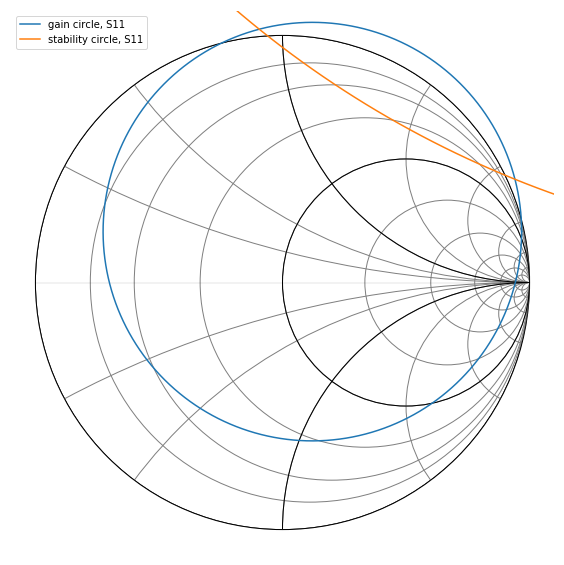

In [9]:
load_points = calc_circle(c_p[idx_900mhz, 0, 0], r_p[idx_900mhz, 0, 0])

load_points_net = net.Network(name='gain circle', s=load_points)
cl_points_net = net.Network(name='stability circle', s=cl_points)

load_points_net.plot_s_smith()
cl_points_net.plot_s_smith()

In [74]:
#np.absolute(bjt.s21.s[idx_900mhz, 0, 0])

c_p_900mhz, r_p_900mhz = c_p[idx_900mhz, 0, 0], r_p[idx_900mhz, 0, 0]
#d = c_p_900mhz - cl_900mhz
#gamma_l = c_p_900mhz + r_p_900mhz * d/np.absolute(d)
gamma_l = c_p_900mhz + r_p_900mhz * (np.exp(1.0j*np.pi*1.5))
gamma_l = 0.0

# check stability against the stability circle
is_gamma_l_stable = np.absolute(gamma_l - cl_900mhz) > rl_900mhz
gamma_l, is_gamma_l_stable

(0.0, True)

In [14]:
# no output network right now

#z_l = net.s2z(np.array([[[gamma_l]]]))[0, 0, 0]
#print(z_l)

#Q = np.sqrt((50 - np.real(z_l))/np.real(z_l)) 
#x_1 = 50/Q
#x_2 = Q * np.real(z_l)

#print(x_1, x_2)

#z_tmp = 1./(1./50 + 1./(1.0j * x_1))
#x_cl = 1.0j*(np.imag(z_l) - np.imag(z_tmp))
#z_eff = z_tmp + x_cl
#print(z_l, z_tmp, z_eff, x_cl)

# TODO set fc somewhere up above
#l_l = x_1/(2*np.pi*915e+6)
#c_l = 1./(1.0j*2*np.pi*915e+6*x_cl)

#print(l_l, c_l)

(8.445164819672742e-09, (2.197986829275139e-12+0j))

In [15]:
# just to double check, let's apply these two components to S22 and see if the load effectively sees 50 ohms
#z_tmp = z_l - 1.0j/(2*np.pi*915e+6*c_l)
#z_eff = 1/(1.0/z_tmp + 1.0/(1.0j*2*np.pi*915e+6*l_l))
#z_tmp, z_eff

((24.265634184405894-133.2827361378321j),
 (7.363699623976987+74.26471797004312j))

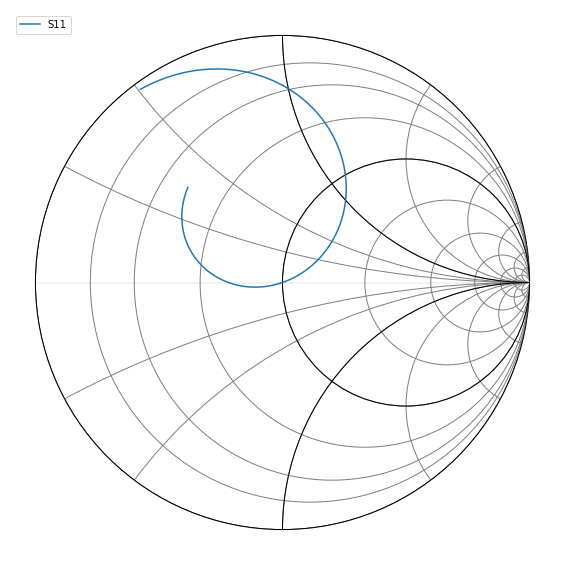

In [16]:
#output_network = tem.capacitor(c_l)**tem.shunt_inductor(l_l)
#output_network_backwards = tem.shunt_inductor(l_l) ** tem.capacitor(c_l)

#output_network

#(output_network_backwards ** tem.load(np.conj(gamma_l))).plot_s_smith()

In [42]:
# woo, it probably works! time to work out the source matching network 
# and then cascade all three of them to see if that works

gamma_in = bjt.s11.s + bjt.s12.s*bjt.s21.s*gamma_l/(1 - bjt.s22.s*gamma_l)
gamma_s = np.conj(gamma_in)
gamma_s = gamma_s[idx_900mhz, 0, 0]

# check stability against the stability circle
is_gamma_s_stable = np.absolute(gamma_s - cs_900mhz) > rs_900mhz
print(gamma_s, is_gamma_s_stable)

((-0.41584748582560843+0.2217514463295517j), True)

In [48]:
# time to calculate the source matching network
z_s = net.s2z(np.array([[[gamma_s]]]))[0, 0, 0]
print(z_s)

Q = np.sqrt((50 - np.real(z_s))/np.real(z_s))
x_1 = 50.0/Q
x_2 = Q*np.real(z_s)

print(x_1, x_2)

z_tmp = 1./(1./50. + 1./(1.0j * x_1))
z_tmp

x_l_s = x_1
x_c_s = -np.imag(z_s) + np.imag(z_tmp)

print(x_l_s, x_c_s)

#c_shunt_s = -1.0/(2*np.pi*915e+6*x_shunt_s)
l_shunt_s = x_l_s/(2*np.pi*915e+6)
c_series_s = 1.0/(2*np.pi*915e+6*x_c_s)
print(l_shunt_s, c_series_s)

# double checking to make sure the match works as expected
z_tmp = 1.0/(1.0/50.0 + 1/(1.0j*2*np.pi*915e+6*l_shunt_s))
z_eff = z_tmp + 1/(1.0j*2*np.pi*915e+6*c_series_s)
print(z_eff)

(18.938017216354385+10.797141060644618j)

True


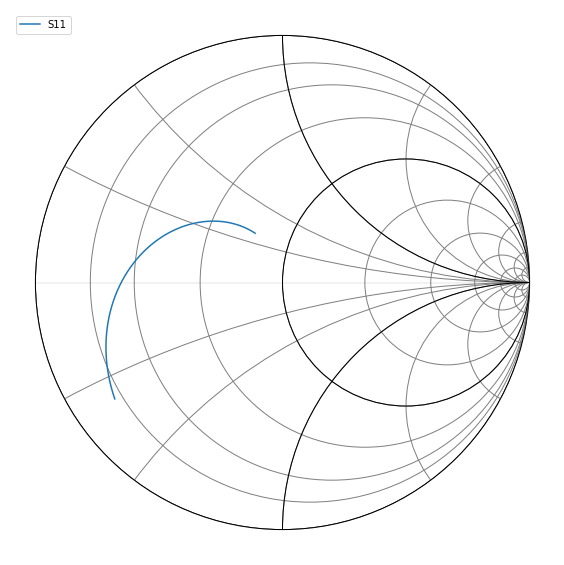

In [69]:
# now to implement it using two port networks
input_network = tem.shunt_inductor(l_shunt_s) ** tem.capacitor(c_series_s)

#check stability by seeing how it looks from the transistor
input_network_backwards = tem.capacitor(c_series_s) ** tem.shunt_inductor(l_shunt_s)
print(np.all(np.absolute(input_network_backwards.s11.s - cs) > rs))
input_network_backwards.s11.plot_s_smith()

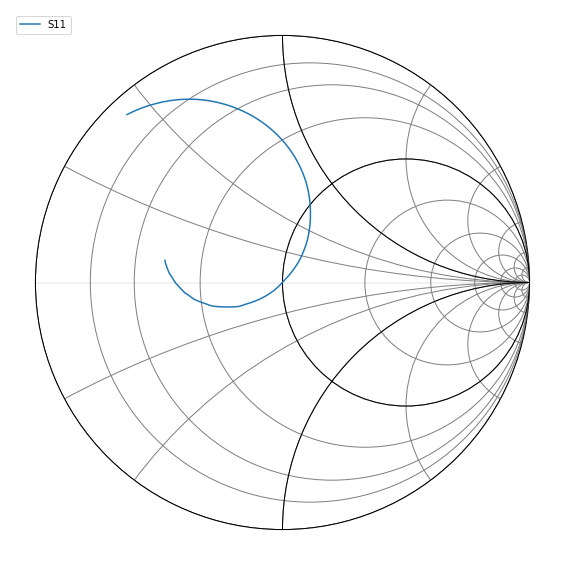

In [49]:
# see how it looks from the source
net.connect(input_network, 1, tem.load(gamma_in), 0).plot_s_smith()

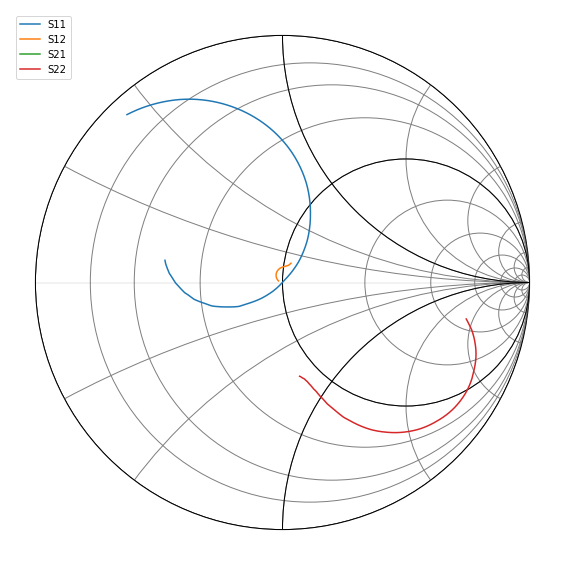

In [76]:
# let's see what the final network looks like
#output_network = tem.capacitor(c_l) ** tem.shunt_inductor(l_l)
input_network = tem.shunt_inductor(l_shunt_s) ** tem.capacitor(c_series_s)

amplifier = input_network ** bjt #** output_network
amplifier.plot_s_smith()

In [56]:
gain = np.square(np.absolute(amplifier.s21.s[idx_900mhz]))
10*np.log10(gain), gain

(array([[19.36994703]]), array([[86.49573695]]))

In [57]:
np.absolute(amplifier.s12.s[idx_900mhz])

array([[0.0618755]])

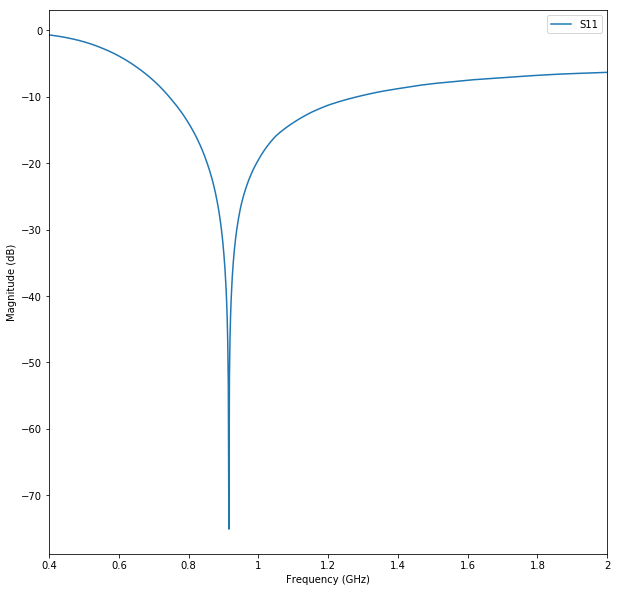

In [58]:
amplifier.s11.plot_s_db()

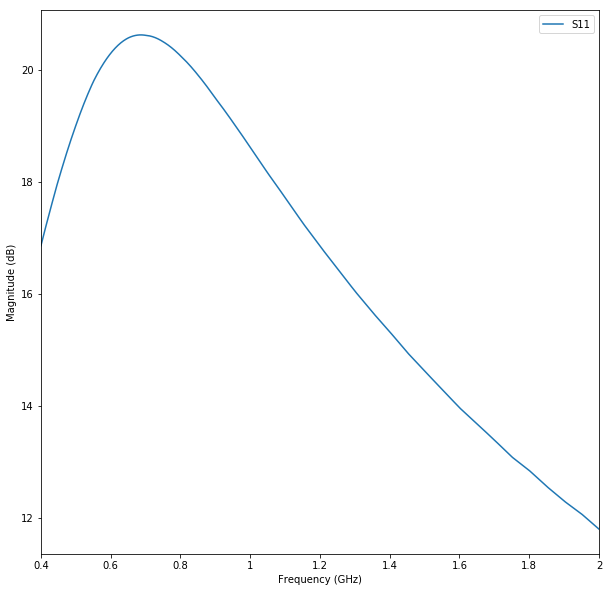

In [59]:
amplifier.s21.plot_s_db()

(2.197986829275139e-12+0j) 8.445164819672742e-09 1.01666044733642e-08 7.633293625570597e-12


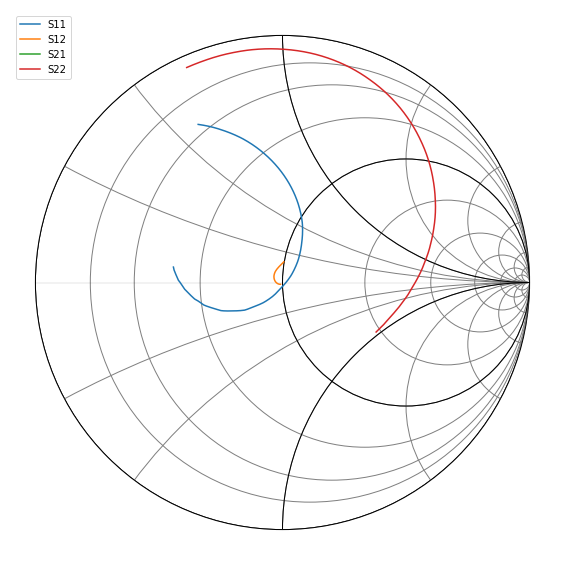

In [29]:
# let's see what the final network looks like with imperfect components
print(c_l, l_l, l_shunt_s, c_series_s)
output_network2 = tem.capacitor(3.9e-12) ** tem.shunt_inductor(12e-9)
input_network2 = tem.shunt_inductor(9.5e-9) ** tem.capacitor(12e-12)

amplifier2 = input_network2 ** bjt ** output_network2
amplifier2.plot_s_smith()

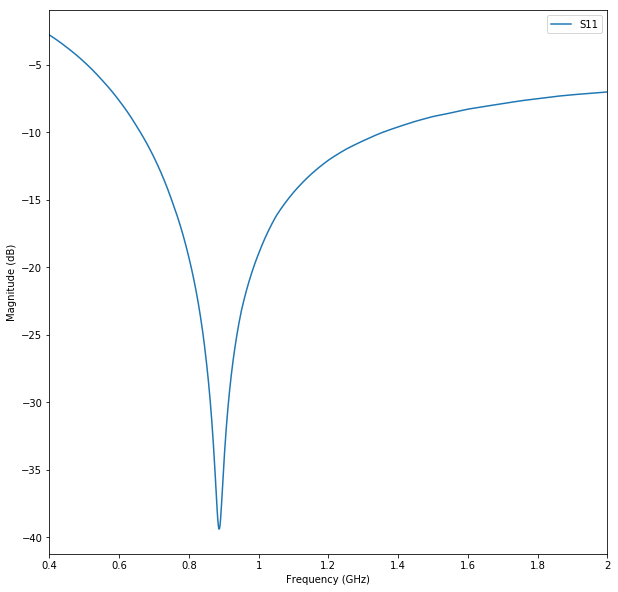

In [30]:
amplifier2.s11.plot_s_db()

[[53.72251584]]


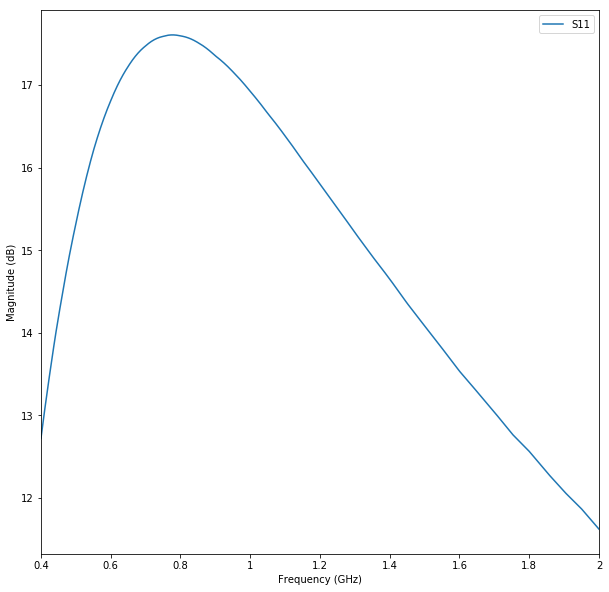

In [31]:
print(np.square(np.absolute(amplifier2.s21.s[idx_900mhz])))
amplifier2.s21.plot_s_db()

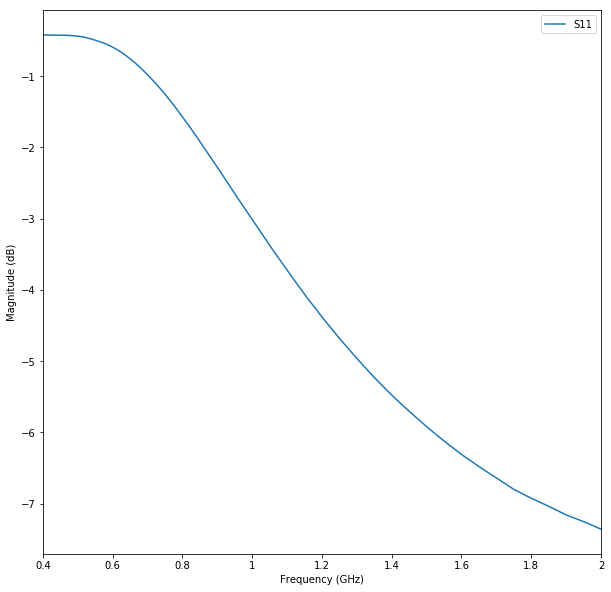

In [32]:
amplifier2.s22.plot_s_db()